## 2. Visualizations and Time Series Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

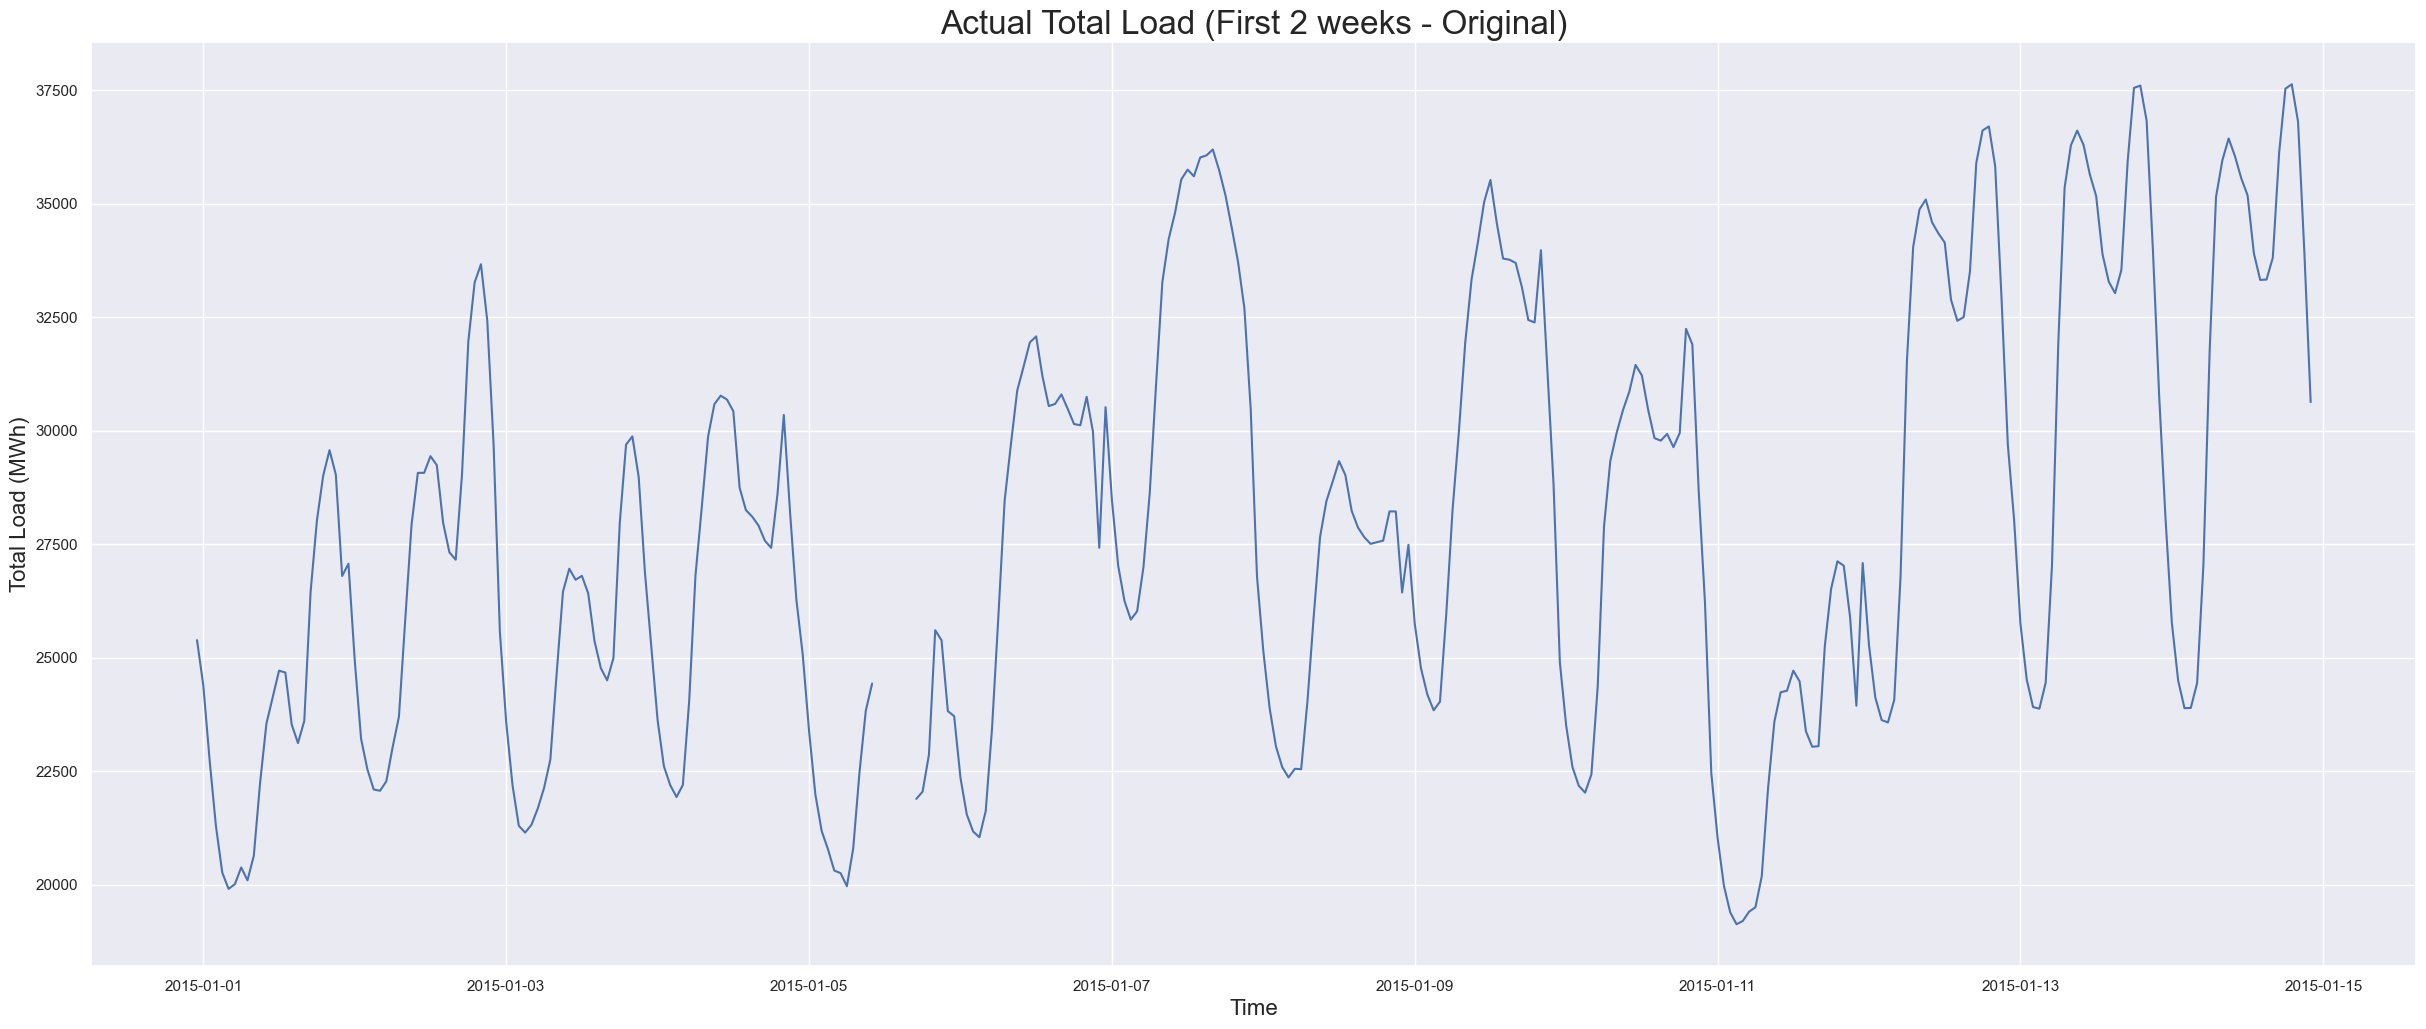

Non-zero values in each column:

generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22450
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
total load actual                              35064
price day ahead                                35064
price actual                                   35064
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178

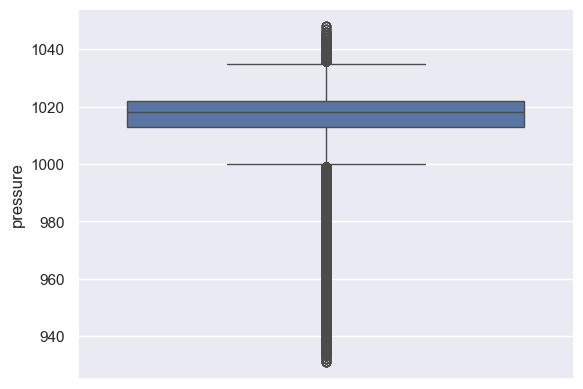

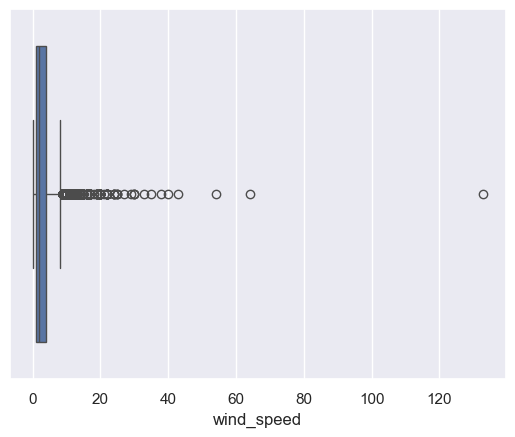

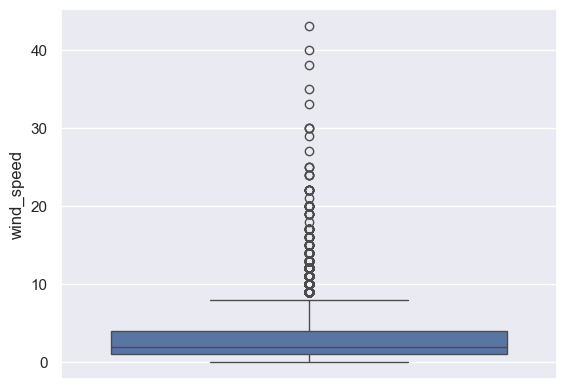

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


<string>:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.


In [2]:
#Packages 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import import_ipynb
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from preprocessing import *

In [4]:
# Data Import 
with open('data/df_final_pre.pkl', 'rb') as f:
    df_final = pickle.load(f)

print(df_final)

                           generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00  

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 72 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

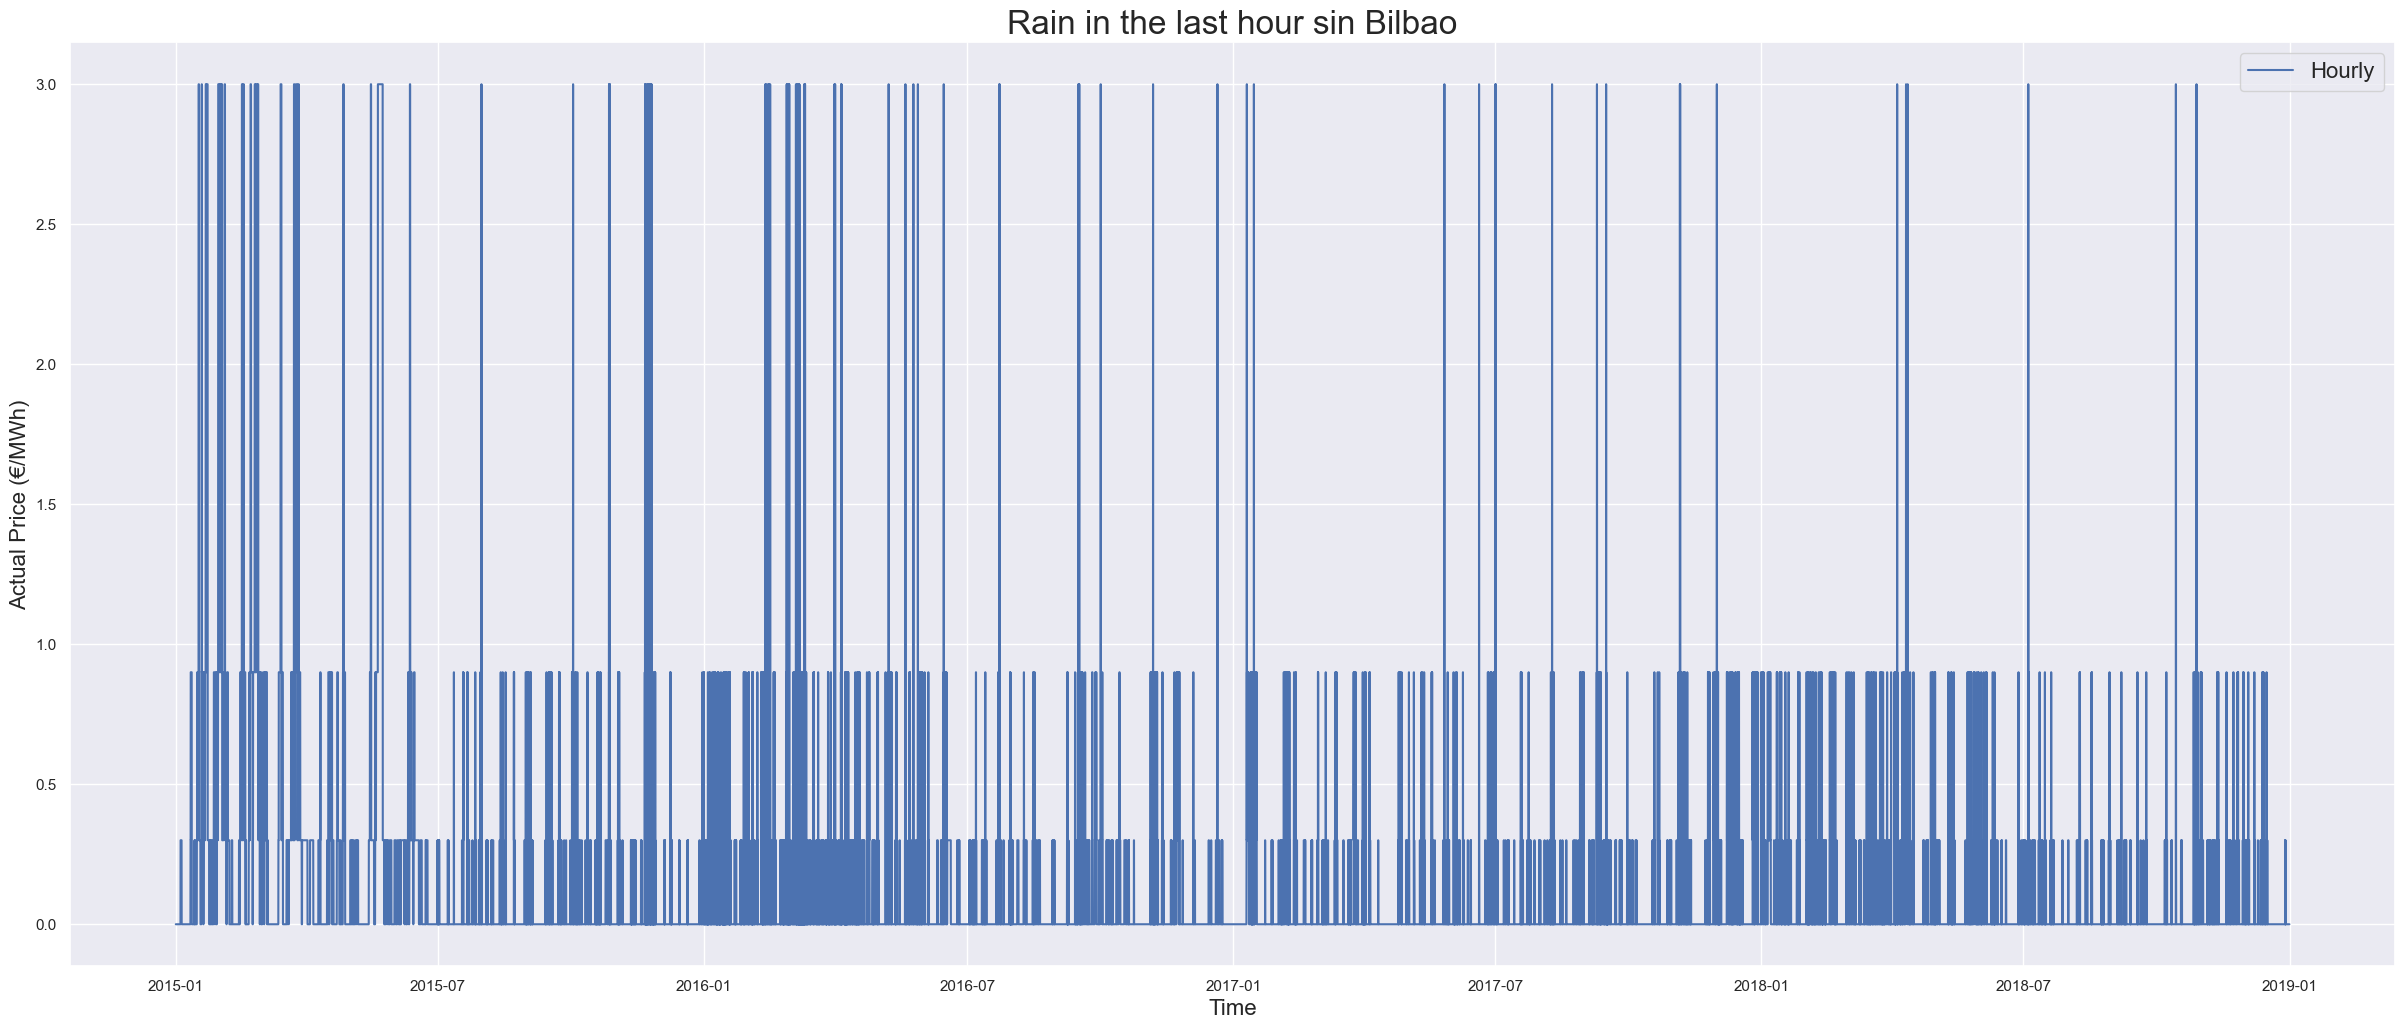

In [ ]:
# Plot the 'rain_1h' for Bilbao


ax = plot_series(df_final, 'rain_1h_Bilbao', 
                 label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour sin Bilbao')
plt.show()

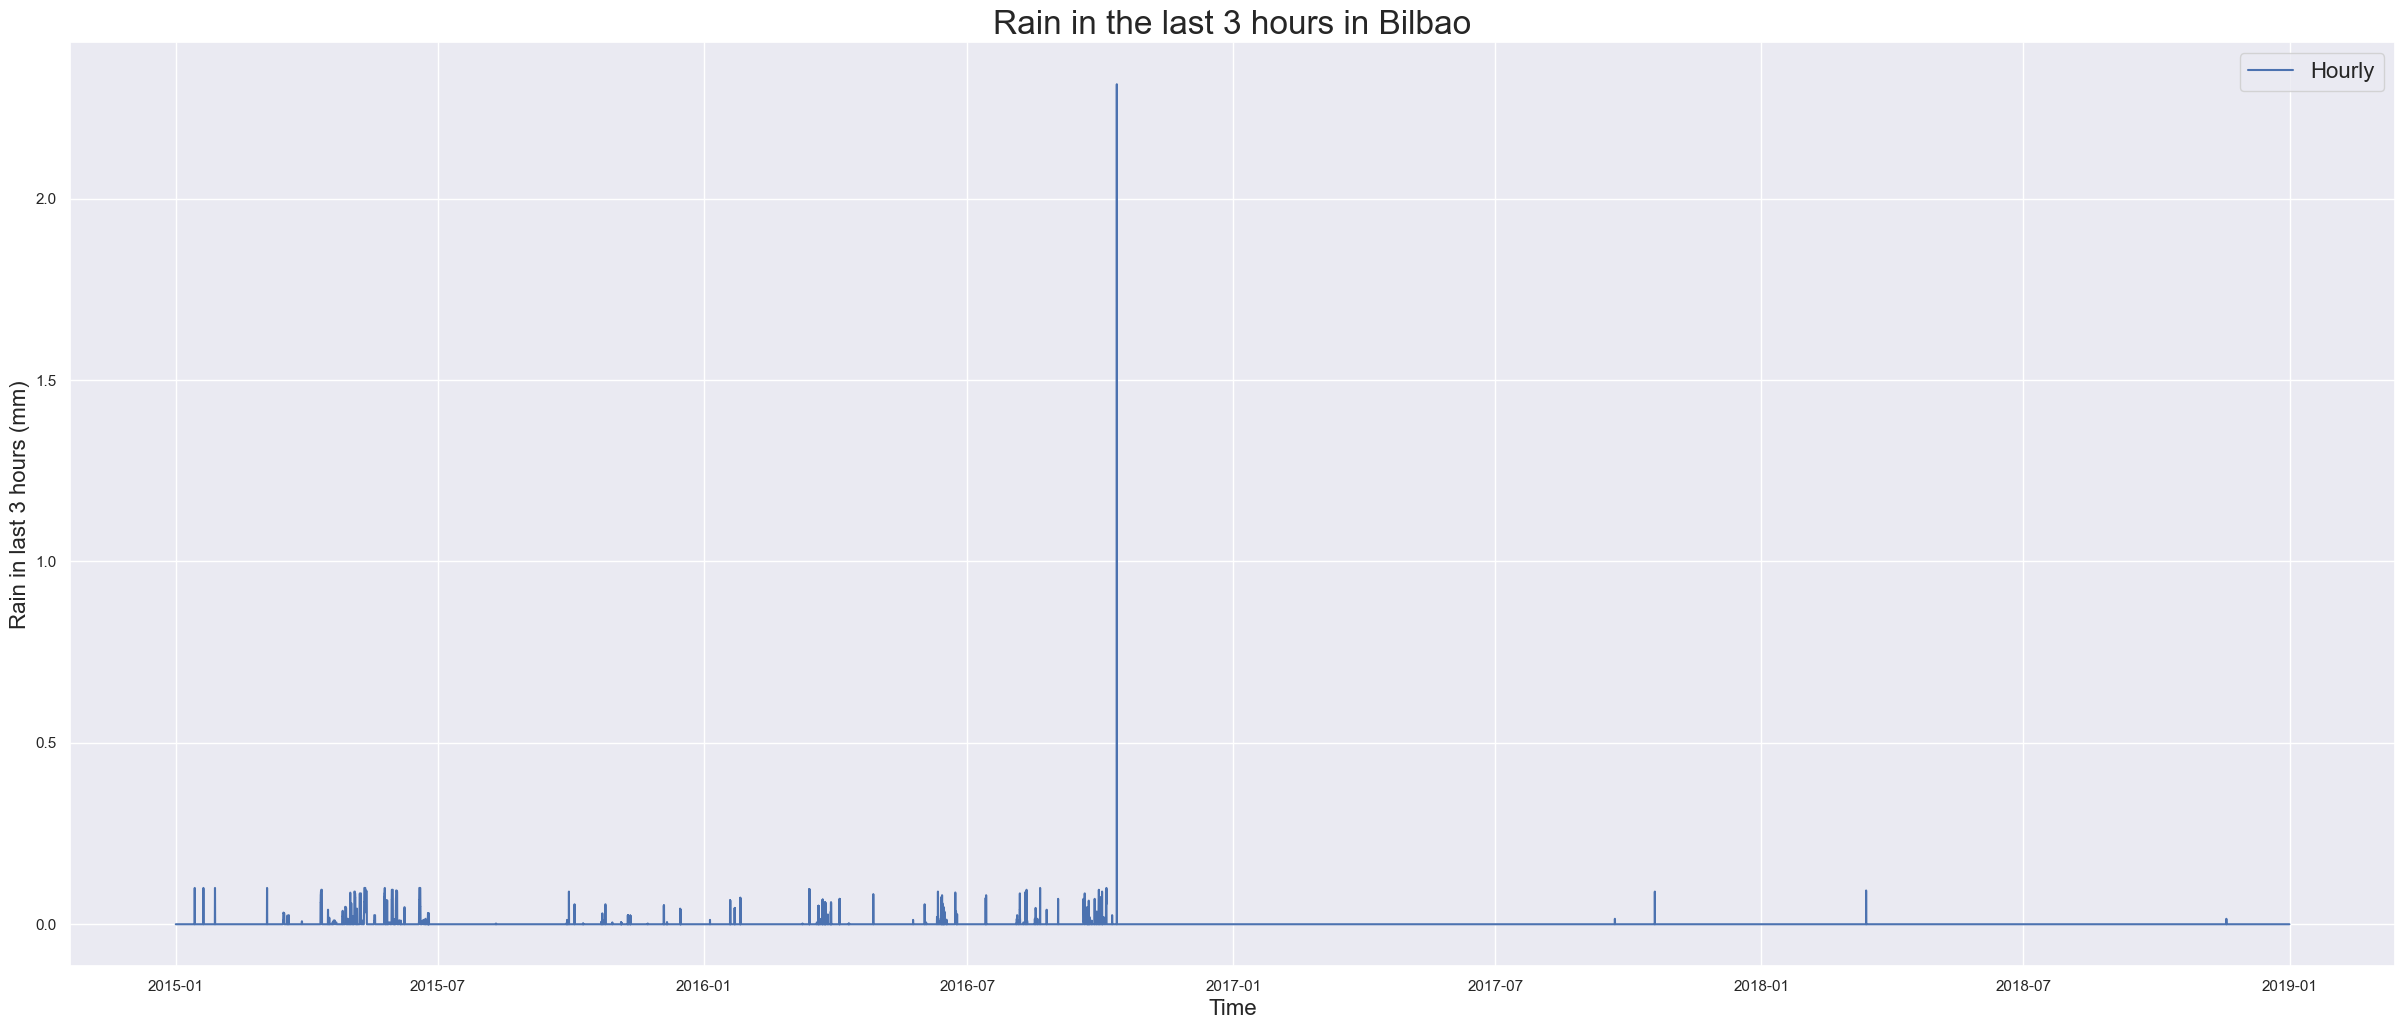

In [ ]:
# Plot the 'rain_3h' for Bilbao

ax = plot_series(df_final, 'rain_3h_Bilbao', 
                 label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()

In [ ]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

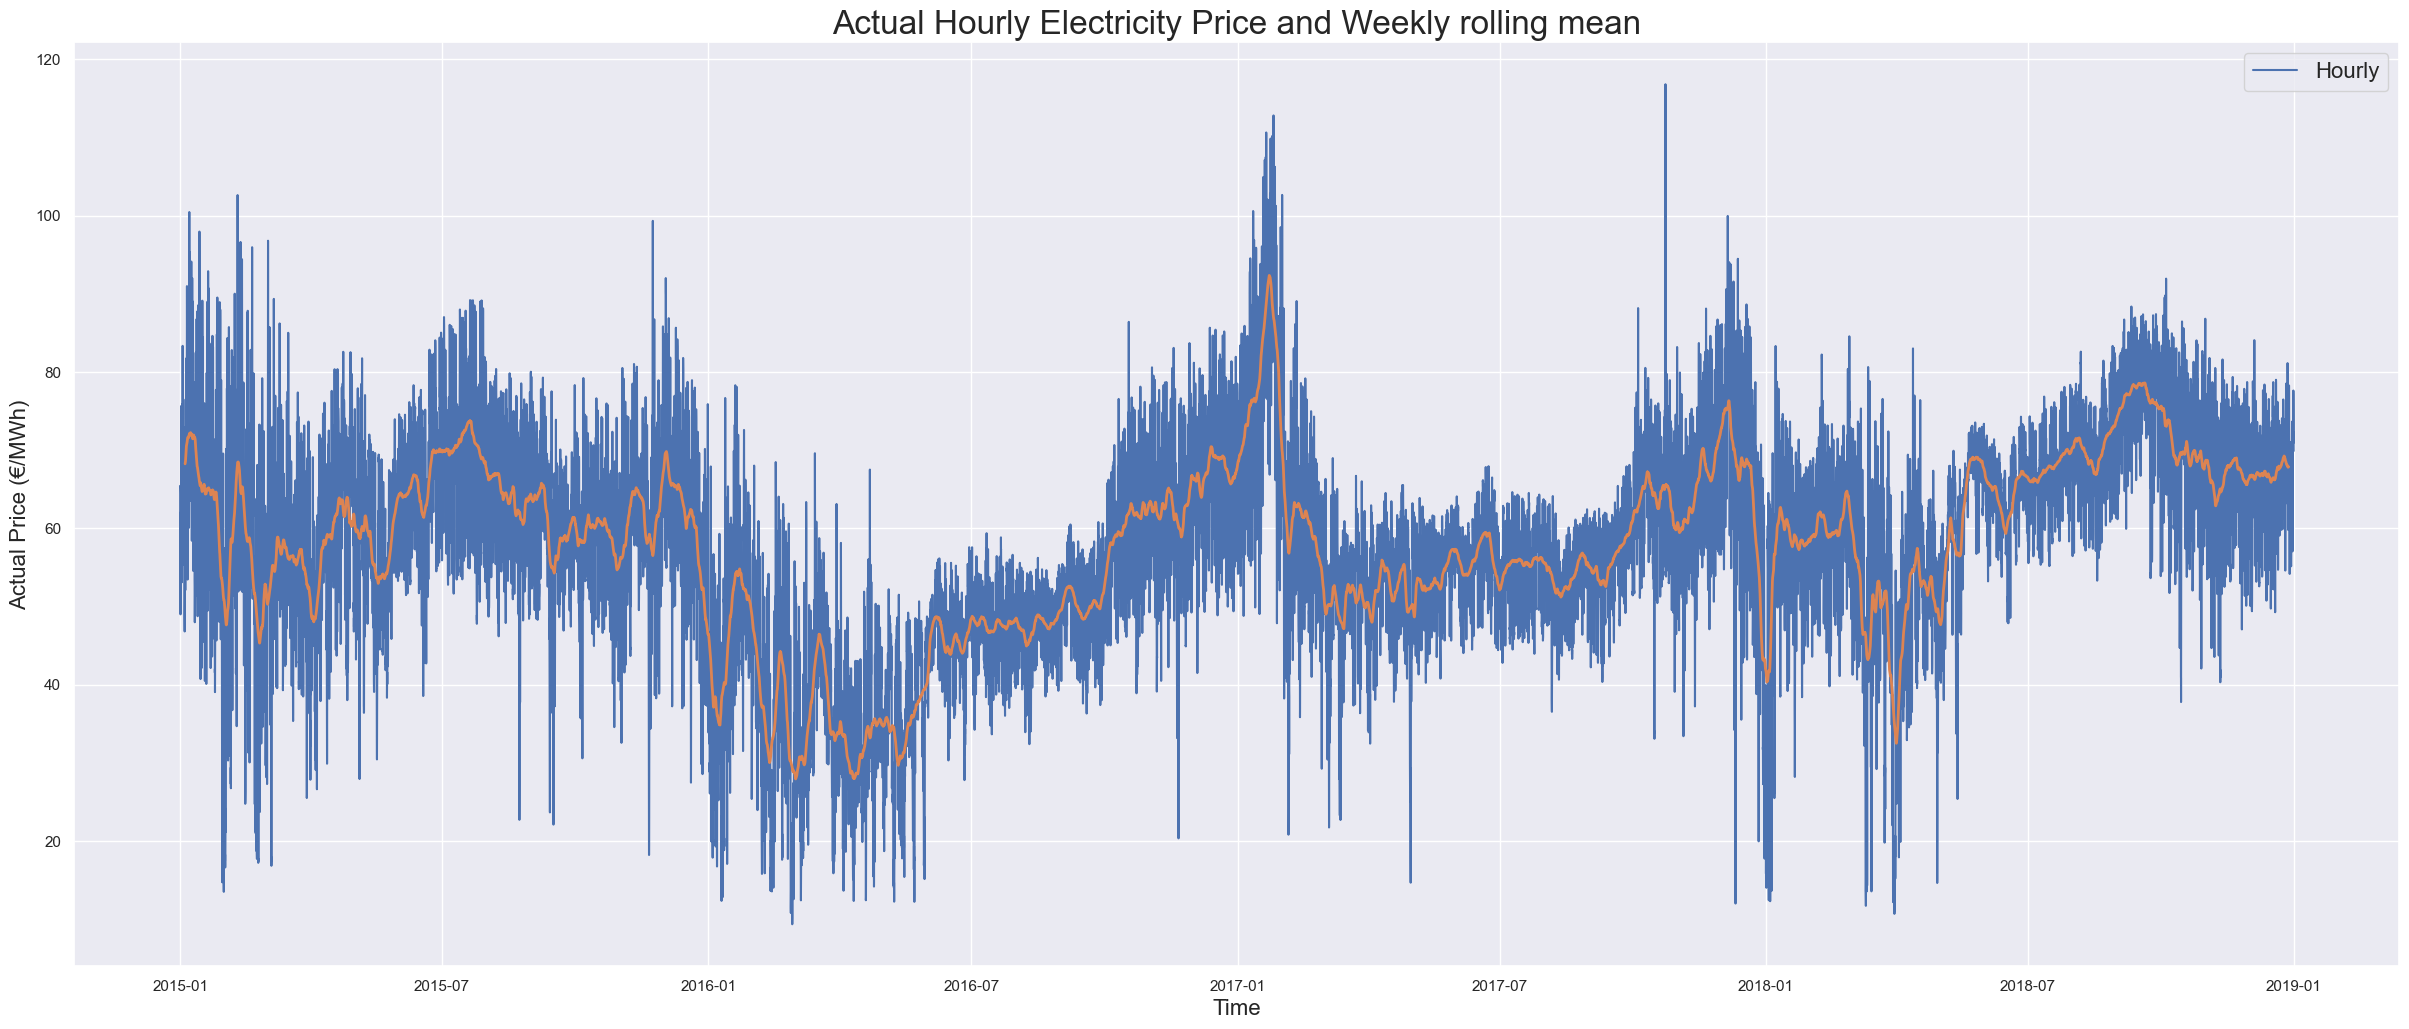

In [ ]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

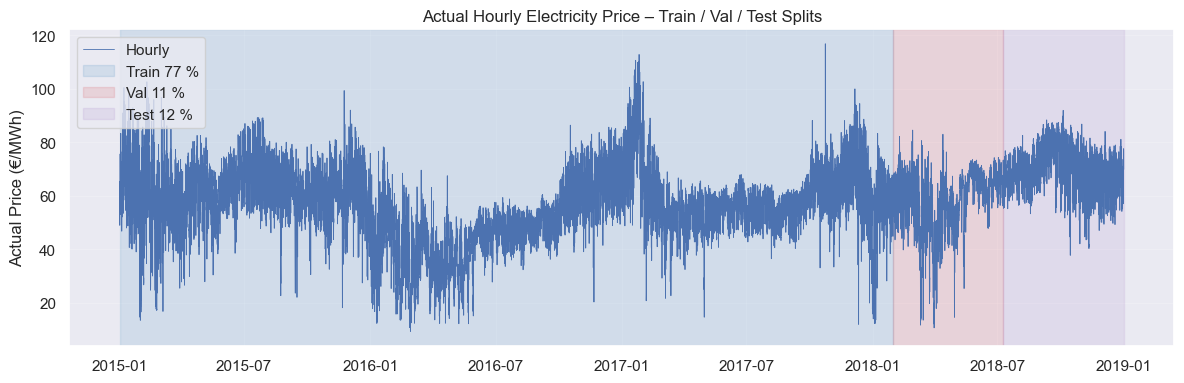

In [6]:
import matplotlib.pyplot as plt

# -----------------------------
# Daten + Rolling-Mean vorbereiten
# -----------------------------
y      = df_final['price actual']
index  = y.index                    # DateTimeIndex
roll7d = y.rolling(24*7, center=True).mean()

# -----------------------------
# Grenzen der Splits berechnen
# -----------------------------
n      = len(y)
train_end = int(n * 0.77)
val_end   = int(n * 0.88)           # 77 % + 11 %

ts_train_end = index[train_end]
ts_val_end   = index[val_end]

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(12,4))

# 1) Preis & Rolling Mean
ax.plot(index, y,        lw=0.6, label='Hourly')

# 2) farbige Bereiche
ax.axvspan(index[0],      ts_train_end,  color='#1f77b4', alpha=0.12, label='Train 77 %')
ax.axvspan(ts_train_end,  ts_val_end,    color='#d62728', alpha=0.12, label='Val 11 %')
ax.axvspan(ts_val_end,    index[-1],     color='#9467bd', alpha=0.12, label='Test 12 %')

# 3) Styling
ax.set_ylabel('Actual Price (€/MWh)')
ax.set_title('Actual Hourly Electricity Price – Train / Val / Test Splits')
ax.legend(loc='upper left')
ax.grid(True, alpha=.2)
plt.tight_layout();  plt.show()

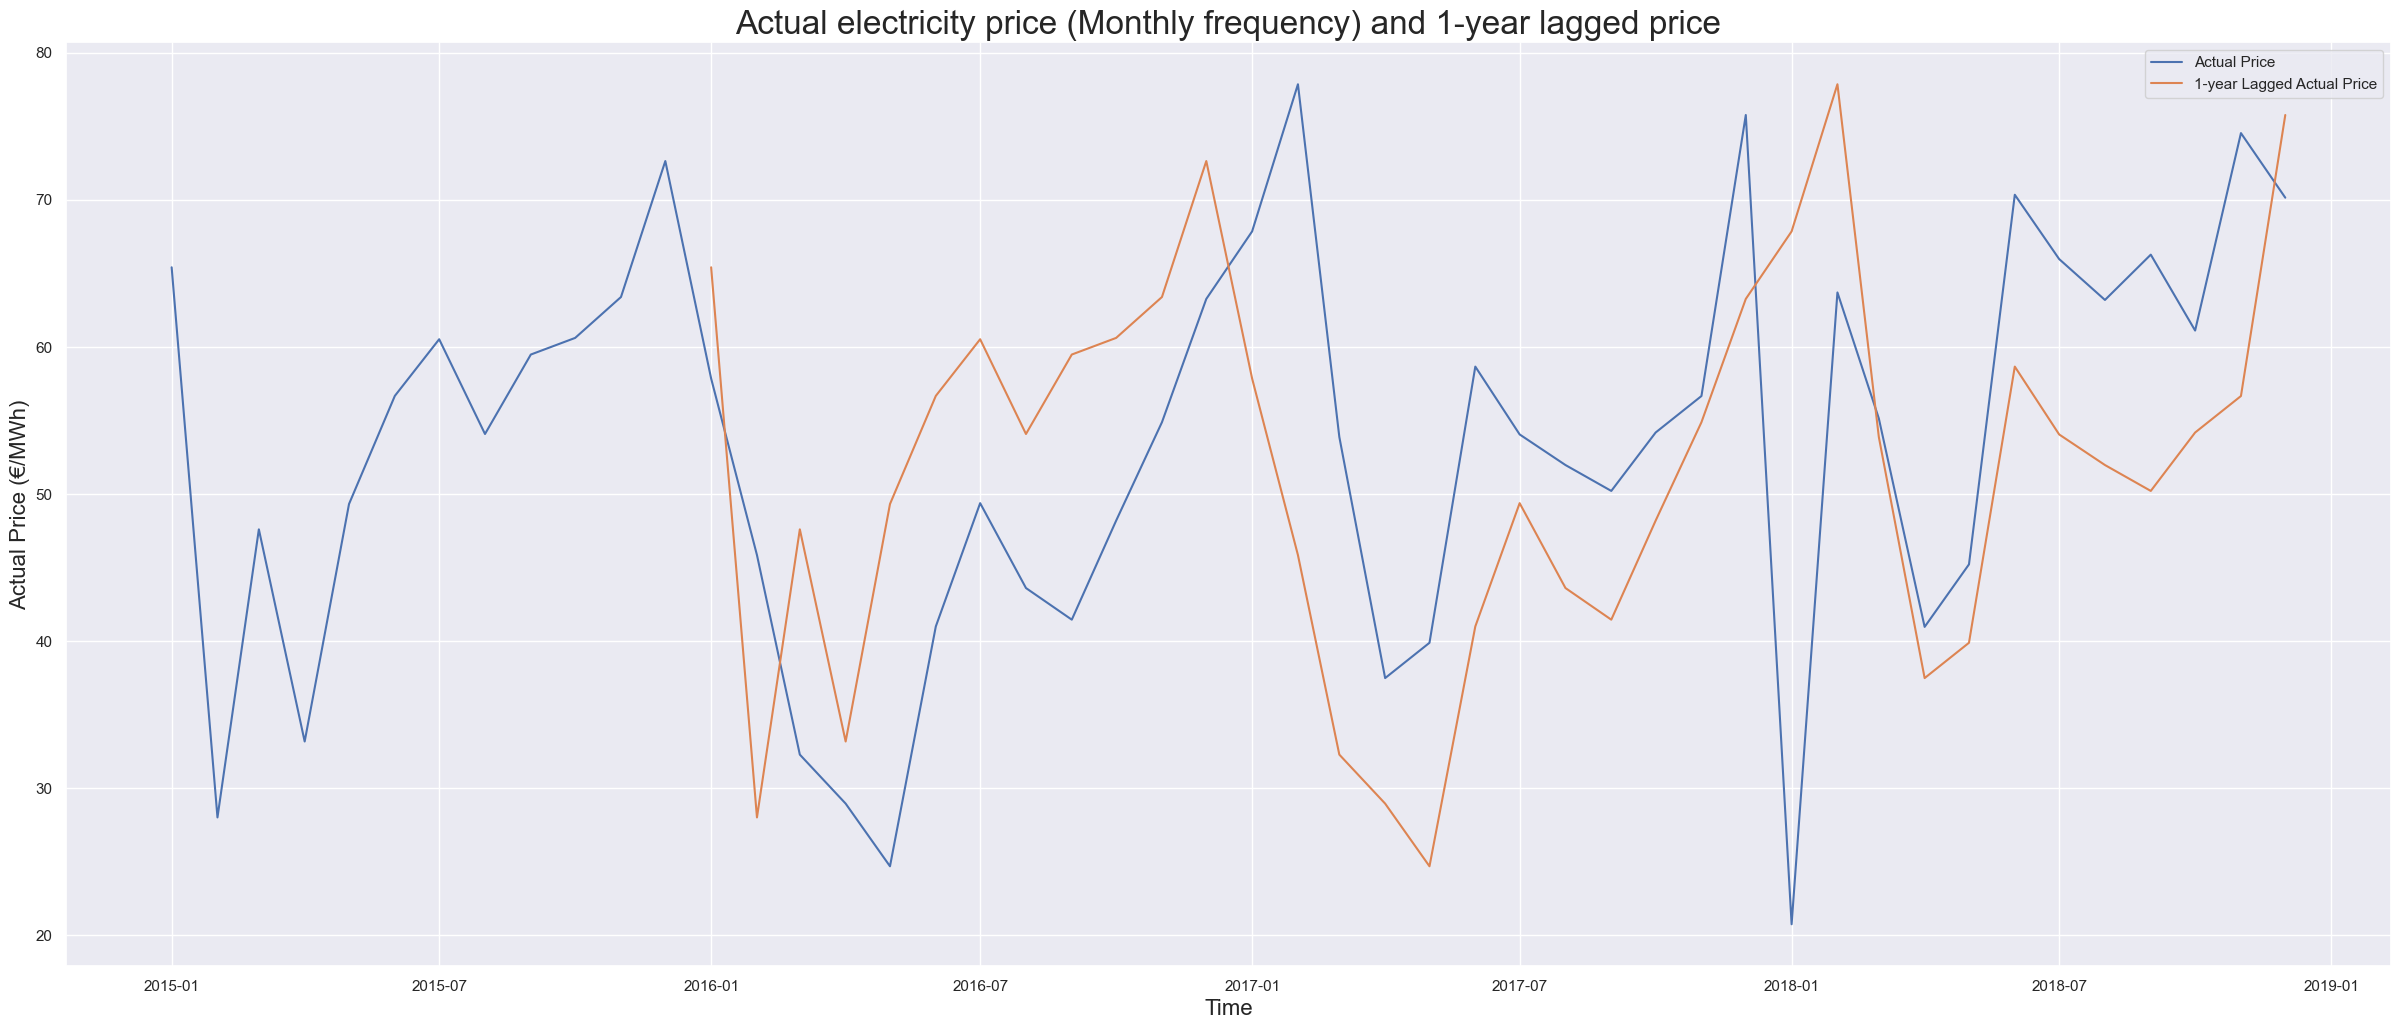

In [53]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series

monthly_price = df_final['price actual'].asfreq('ME')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final['price actual'].asfreq('ME').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

 We can see that there are indeed seasonal patterns at the monthly scale
 

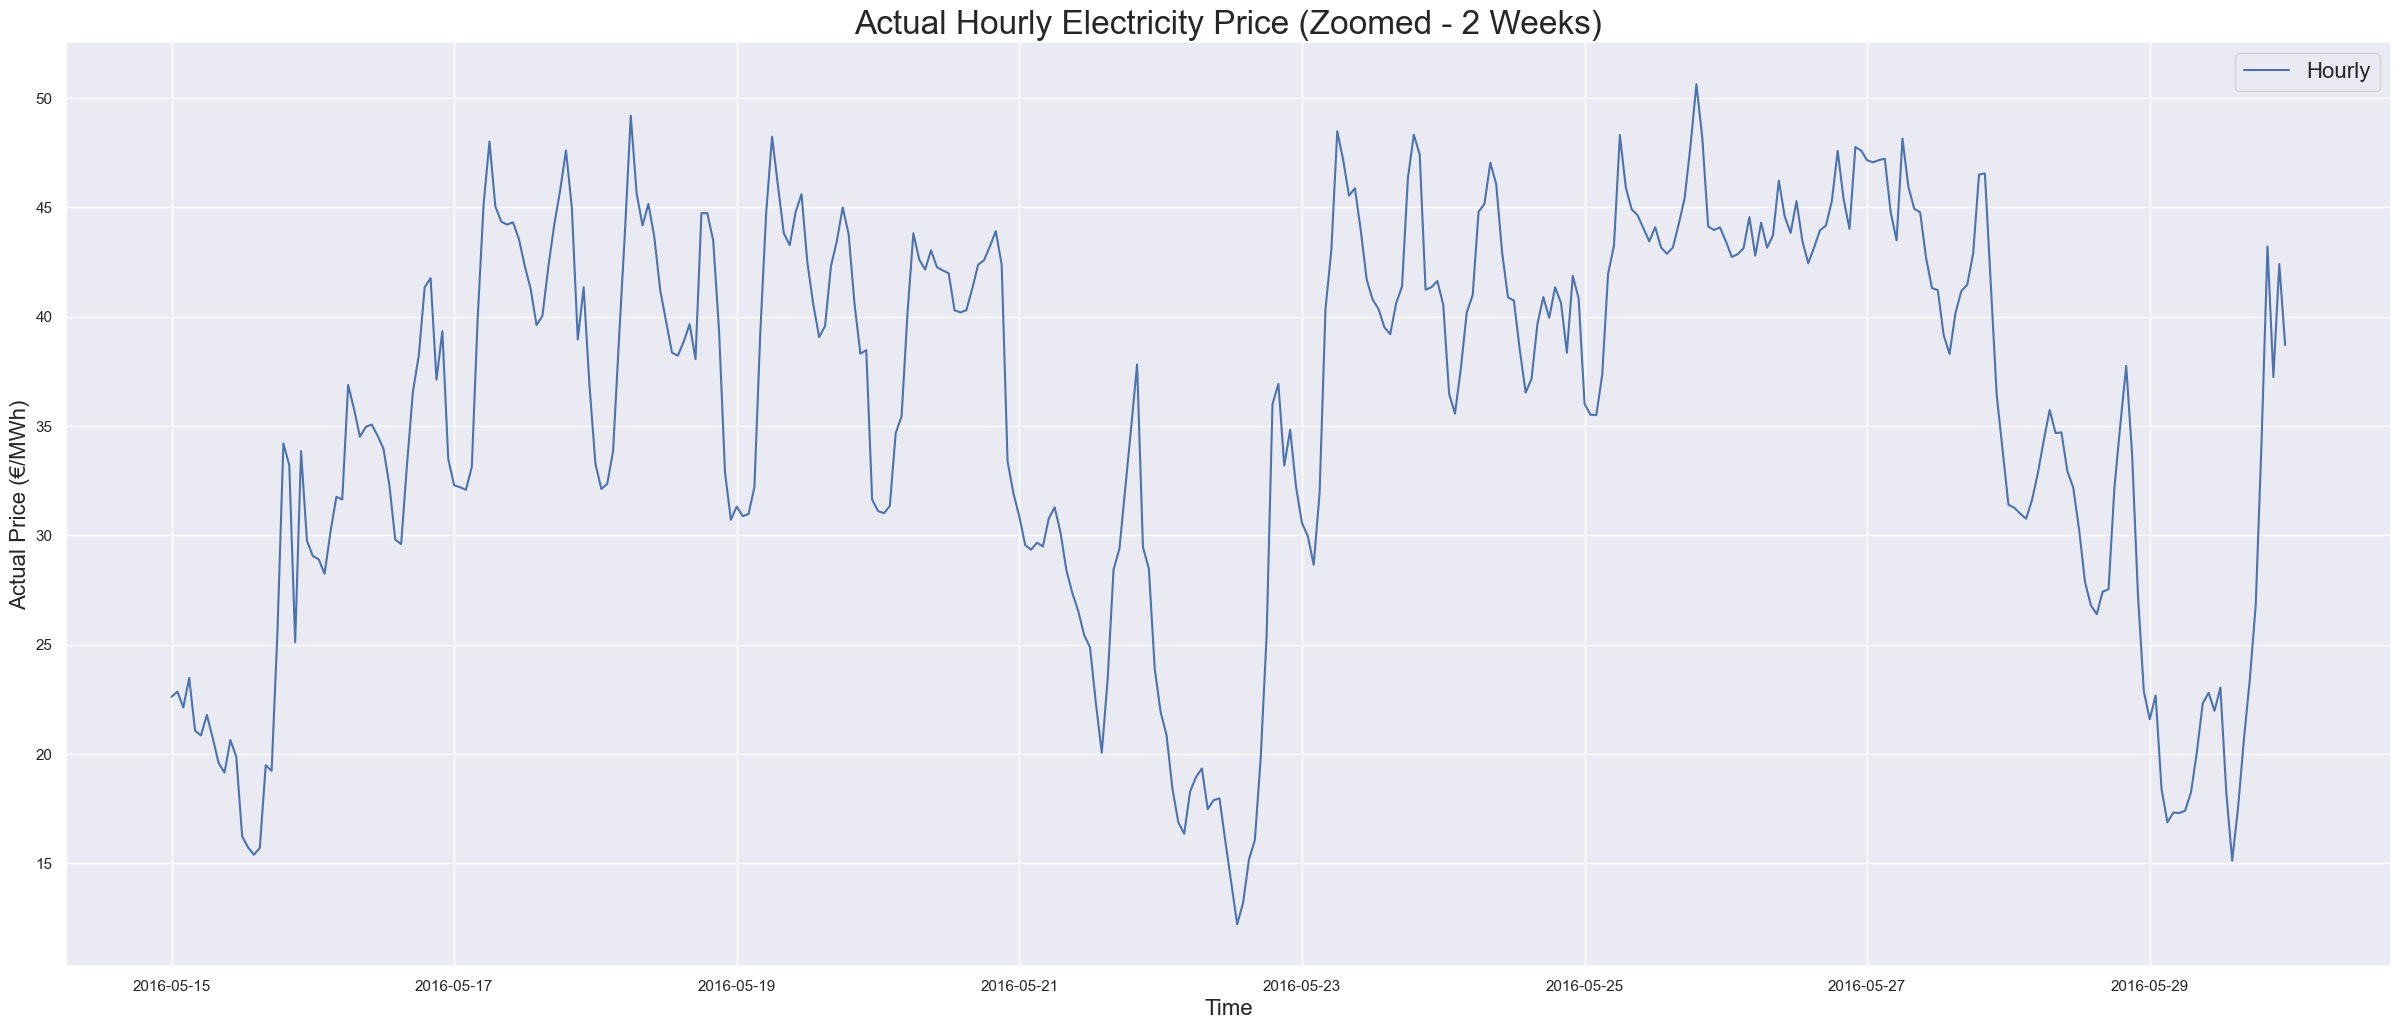

In [54]:
# Plot the actual electricity price at a daily/weekly scale

ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

observed patterns and periodicities:
* periodicity from week to week, price higher during business days and lower during weekends especially on sundays
* intraday periodicity, price is higher during the day and lower during the night
* periodicity within business hours, price drops in some cases for a few hours probably due to siesta

later generate features which contain these kinds of information

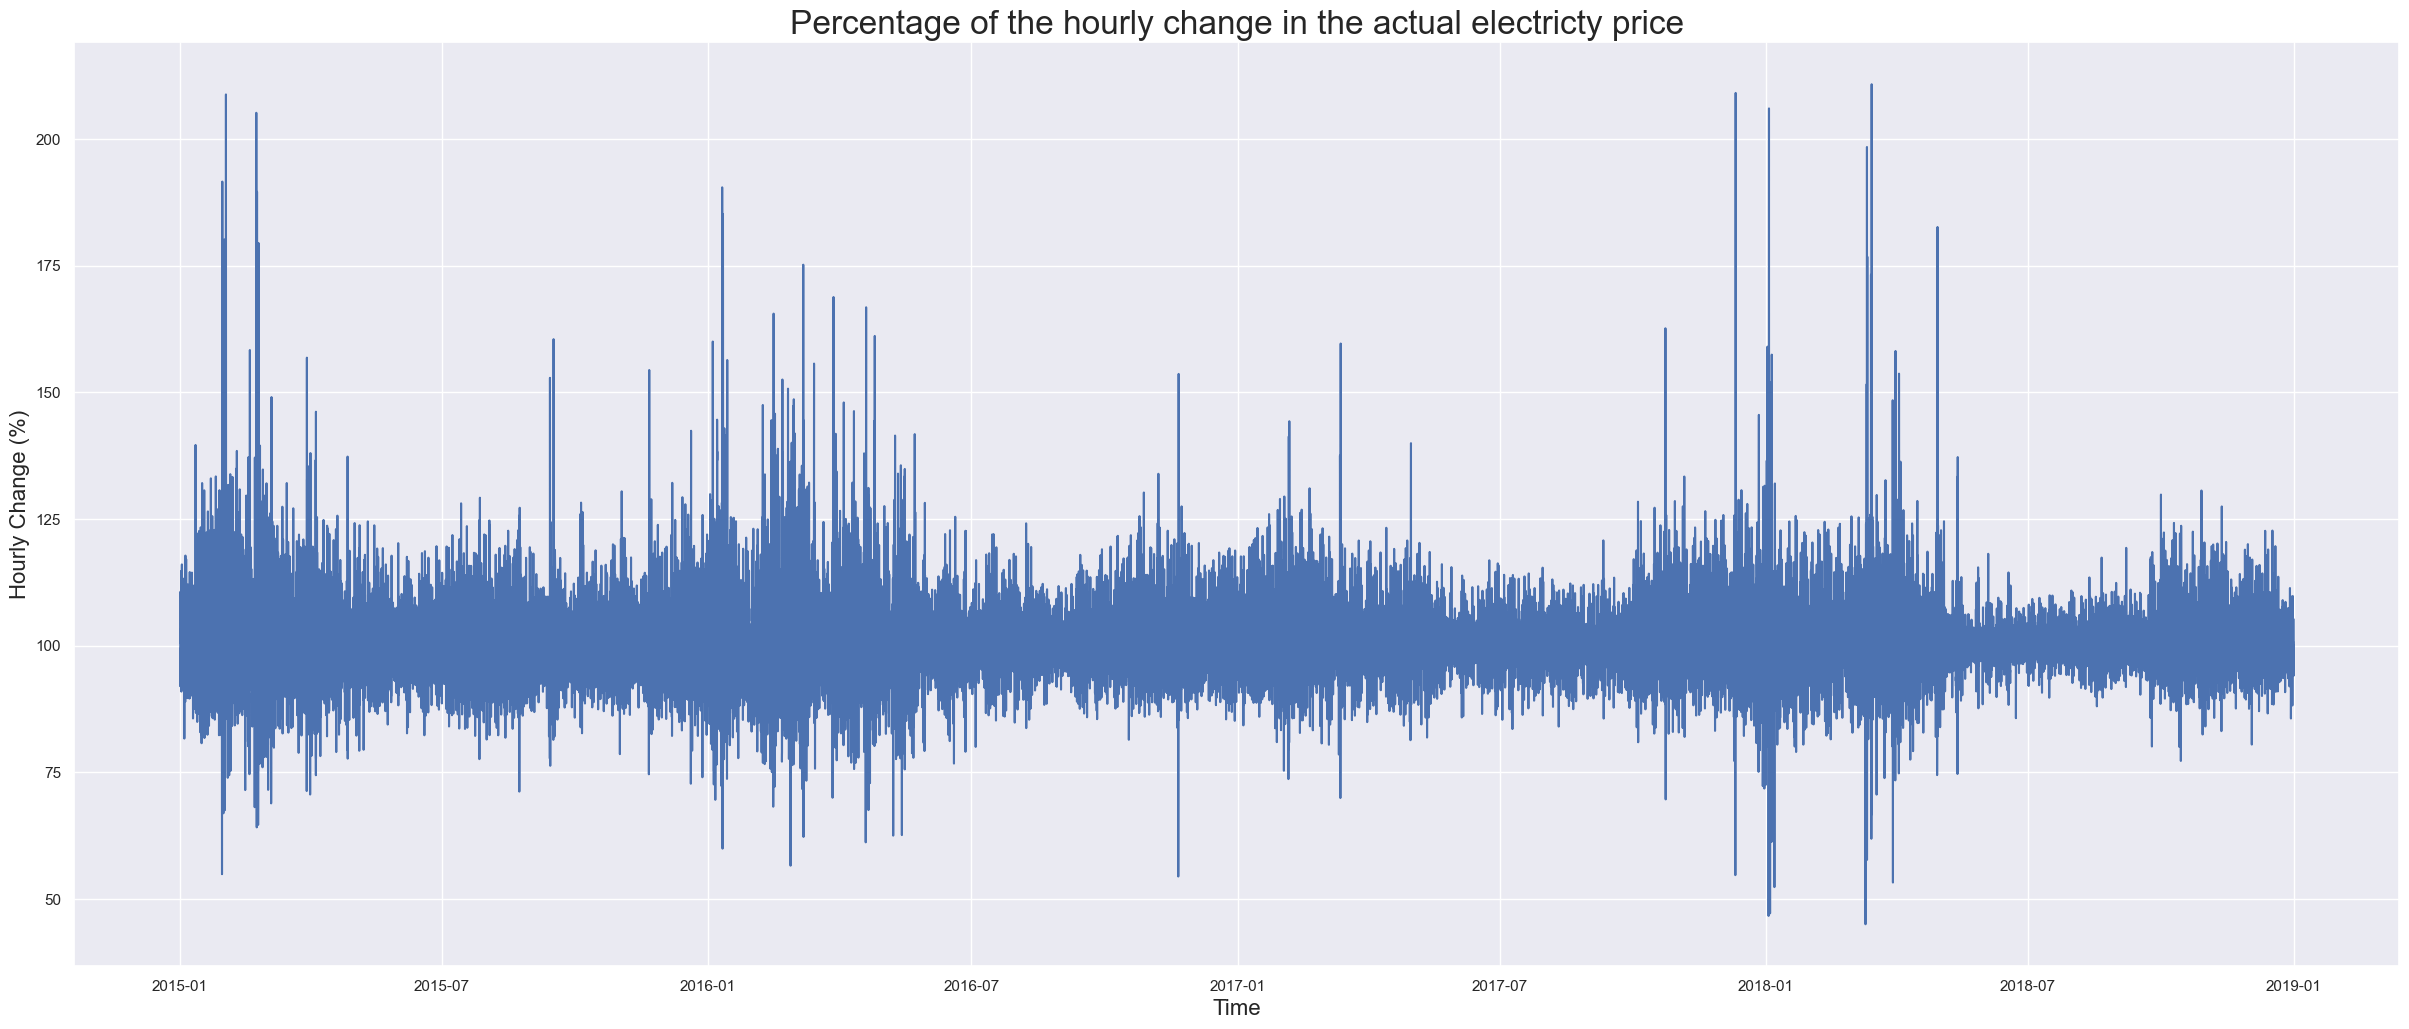

In [55]:
# Plot the percentage of the hourly change in the actual electricity price

change = df_energy['price actual'].div(df_energy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()


From the figure above, we can see that the change in the actual price from hour to hour is in most of the cases between -25% (actual price * 0.75) and +25% (actual price * 1.25). However, there are also very few outliers which show that the price gets halved (-50%) or doubled (+100%).

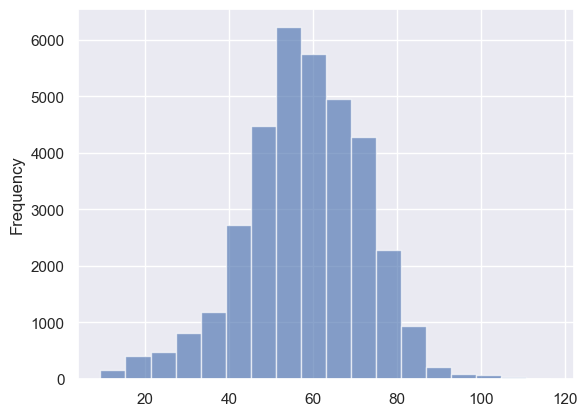

In [56]:
# Plot the histogram of the actual electricity price

ax = df_energy['price actual'].plot.hist(bins=18, alpha=0.65)

## 2.2 Decomposition and stationarity tests

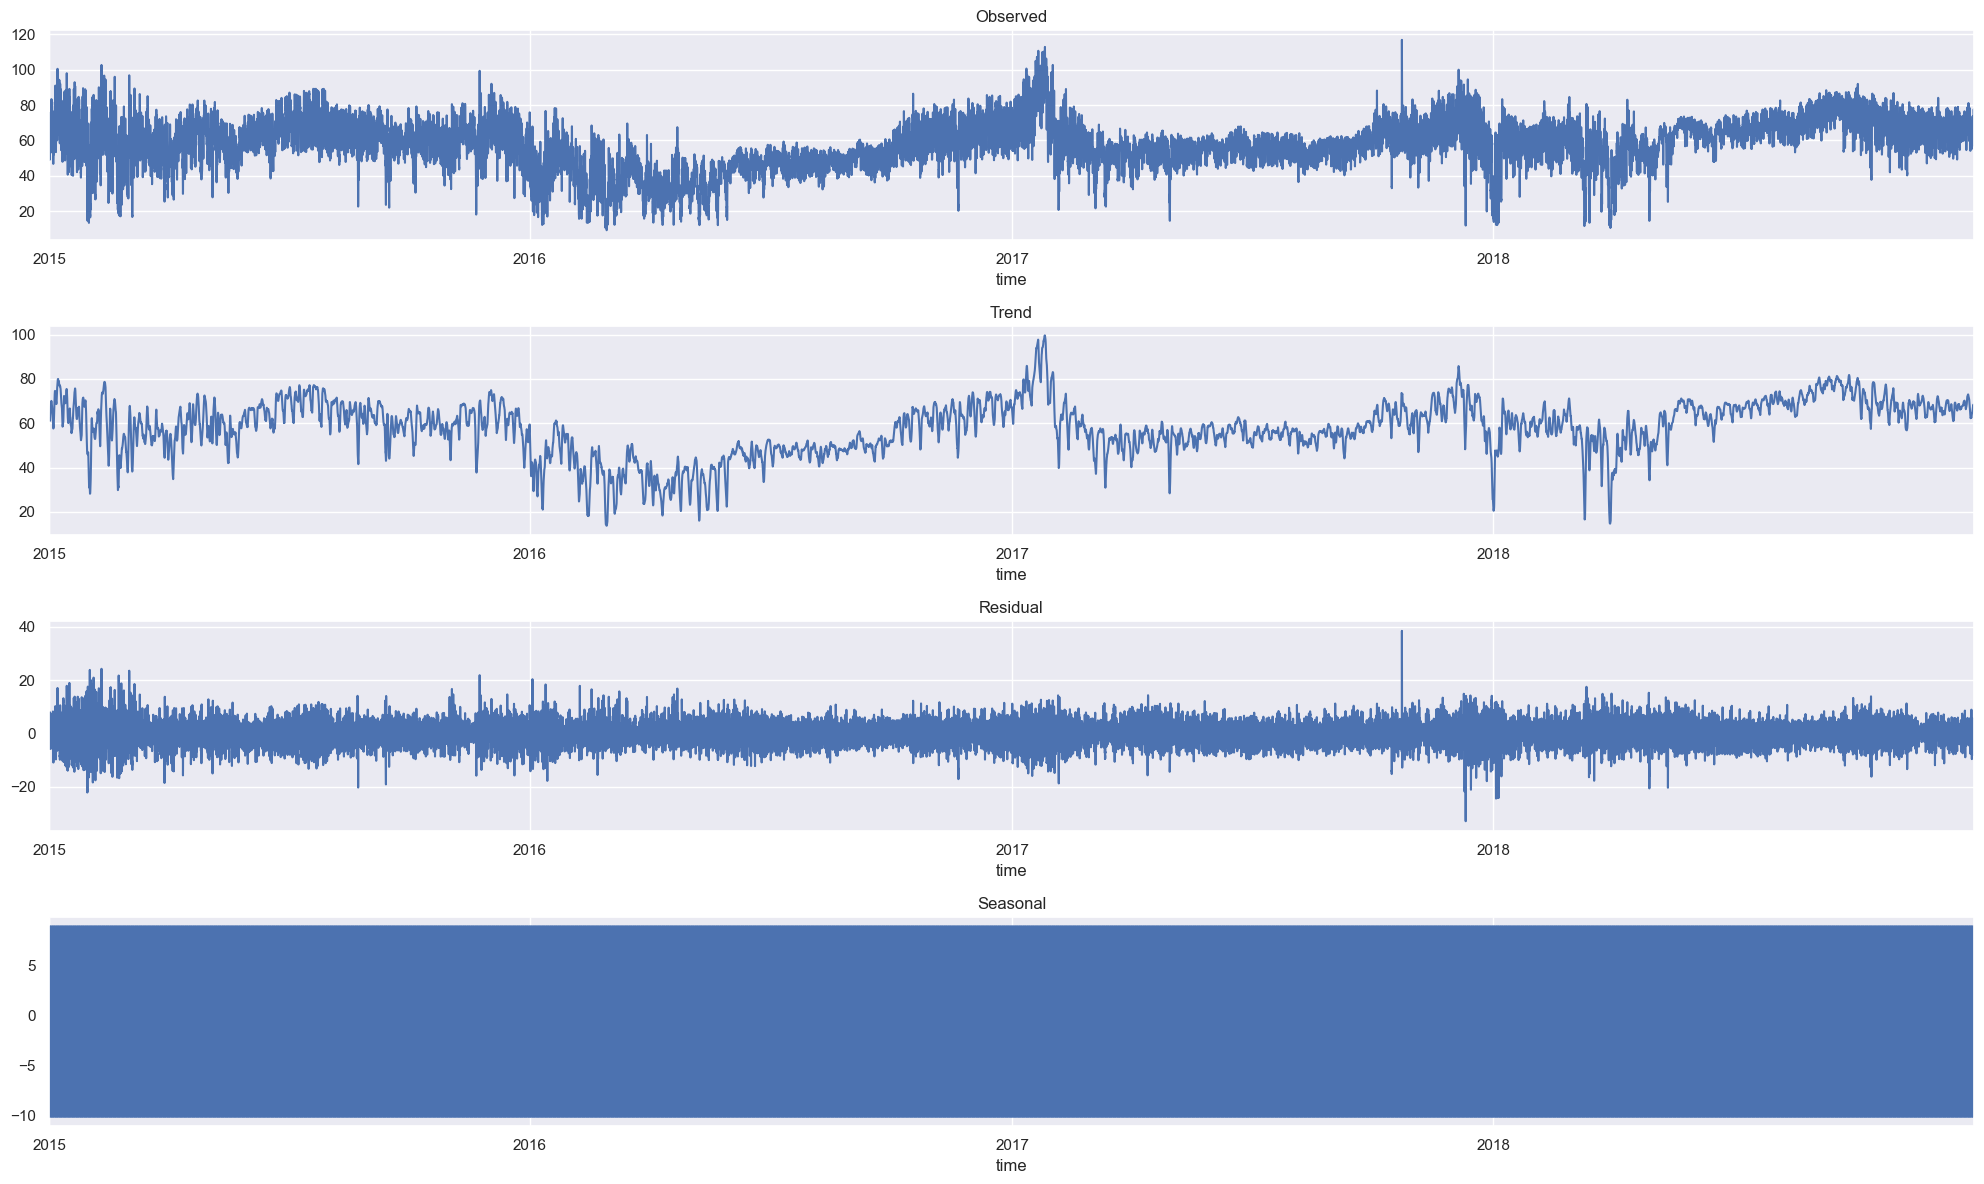

In [57]:
# Decompose the electricity price time series

res = sm.tsa.seasonal_decompose(df_energy['price actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

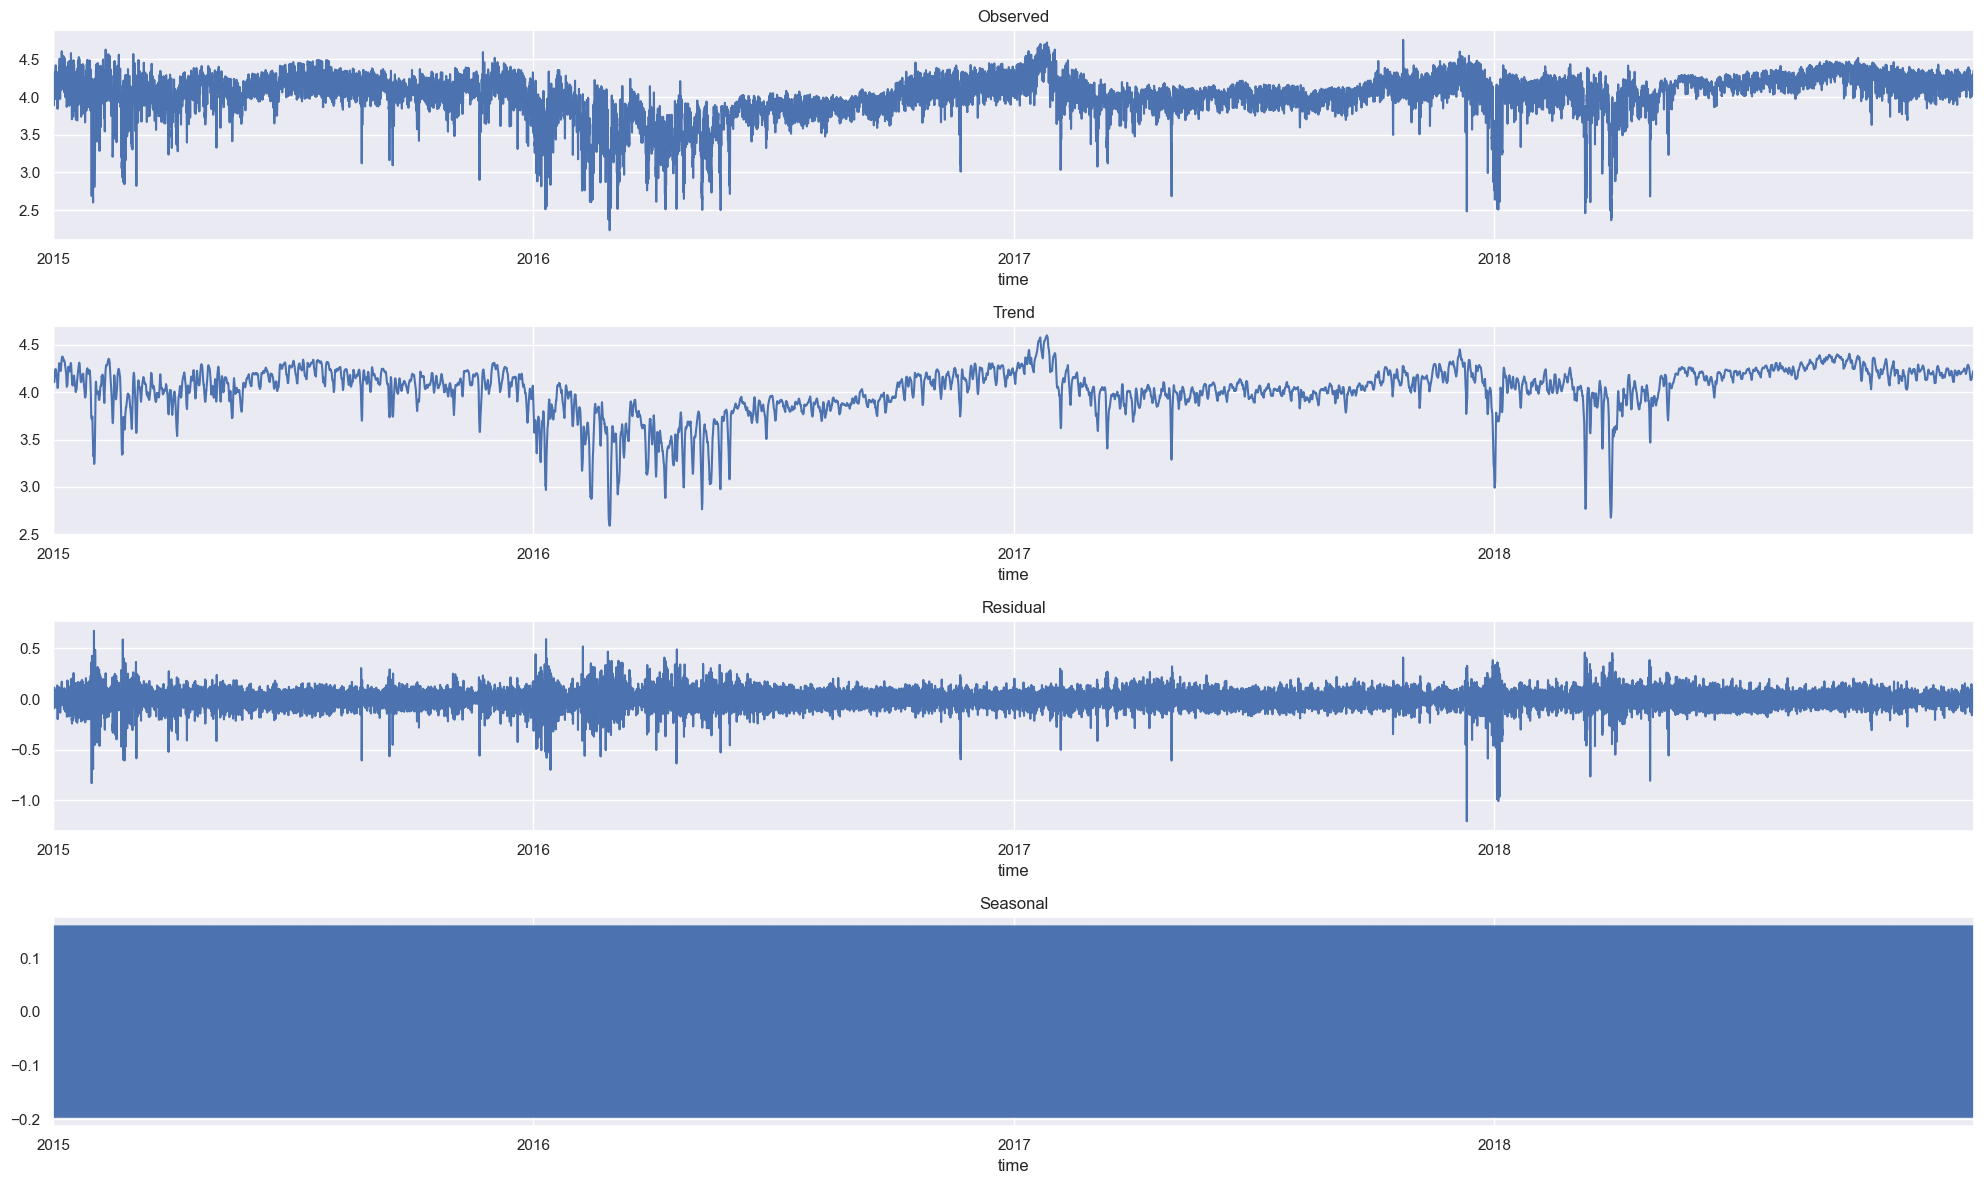

In [58]:
# Decompose the log electricity price time-series

res = sm.tsa.seasonal_decompose(np.log(df_energy['price actual']), model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

**Augmented Dickey-Fuller (ADF) test**, determines how strongly a time series is defined by a trend
* **Null Hytothesis**: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
* **ALternate Hypothesis**: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [59]:
y = df_final['price actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -9.147016
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


ADF statistics (-9.147) < critical value at 1% (-3.431) --> reject null Hypothesis, there is not a root-unit in the time series, target is either stationary or could be made stationary with 1st order differencing

**Kwiatkowski-Phillips-Schmid-Shin (KPSS) test**, checks for stationarity (opposite logic from Augmented Dickey-Fuller test)
* **Null Hypotheses**: The time series is level, i.e. it is stationary around a constant.
* **Alternate Hypothesis**: There is a unit root in the time series and thus it not stationary.

In [60]:
kpss_test = kpss(y, regression='c', nlags='auto')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 4.330034
p-value: 0.010000
#Lags used: 105
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


/var/folders/4w/25khfrw52bj6n9rjl95r9dgw0000gn/T/ipykernel_31504/3937971230.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(y, regression='c', nlags='auto')


KPPS statistic (7.957) is higher than the critical value at 1% (0.739) --> don't reject the null hypothesis, time series is stationary or stationary around a constant

Both tests concluded that the electricity price time series is stationary, while it is also true that deep neural networks can handle such properties in a more forgiving way compared to ARIMA models.

## 2.3 Autocorrelation, partial autocorrelation and cross-correlation

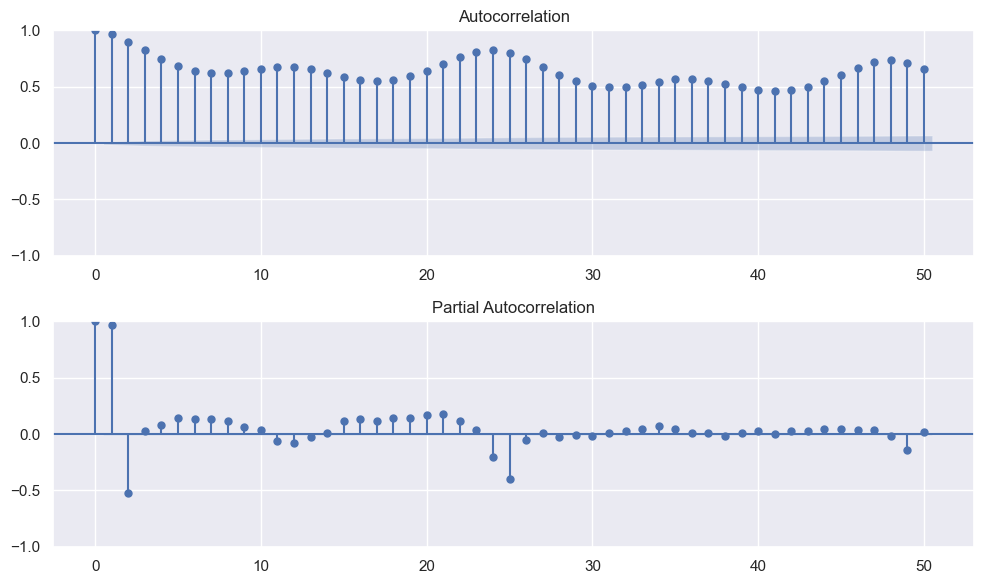

In [61]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

Shows that the direct relationship between an observation at a given hour (t) is strongest with the observations at t-1, t-2, t-24 and t-25 time-steps and diminishes afterwards. Thus, we are going to use the 25 previous values of each time series which will constitute a feature for our models.

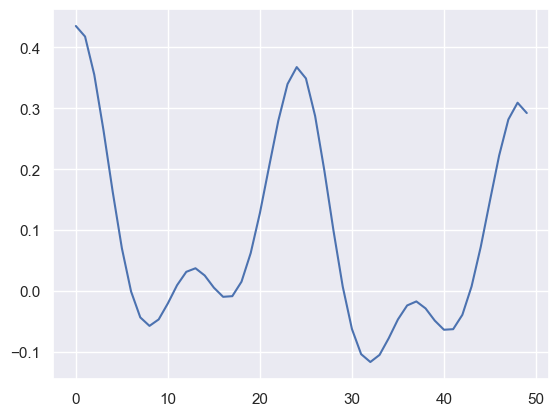

In [62]:
cross_corr = ccf(df_final['total load actual'], df_final['price actual'])
plt.plot(cross_corr[0:50])
plt.show()

In [63]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_final.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.249177
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
pressure_Valencia                              0.109812
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0

In [64]:
# drop 'snow_3h_Barcelona', 'snow_3h_Seville' which give NaNs in ther corr with electricity actual price
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

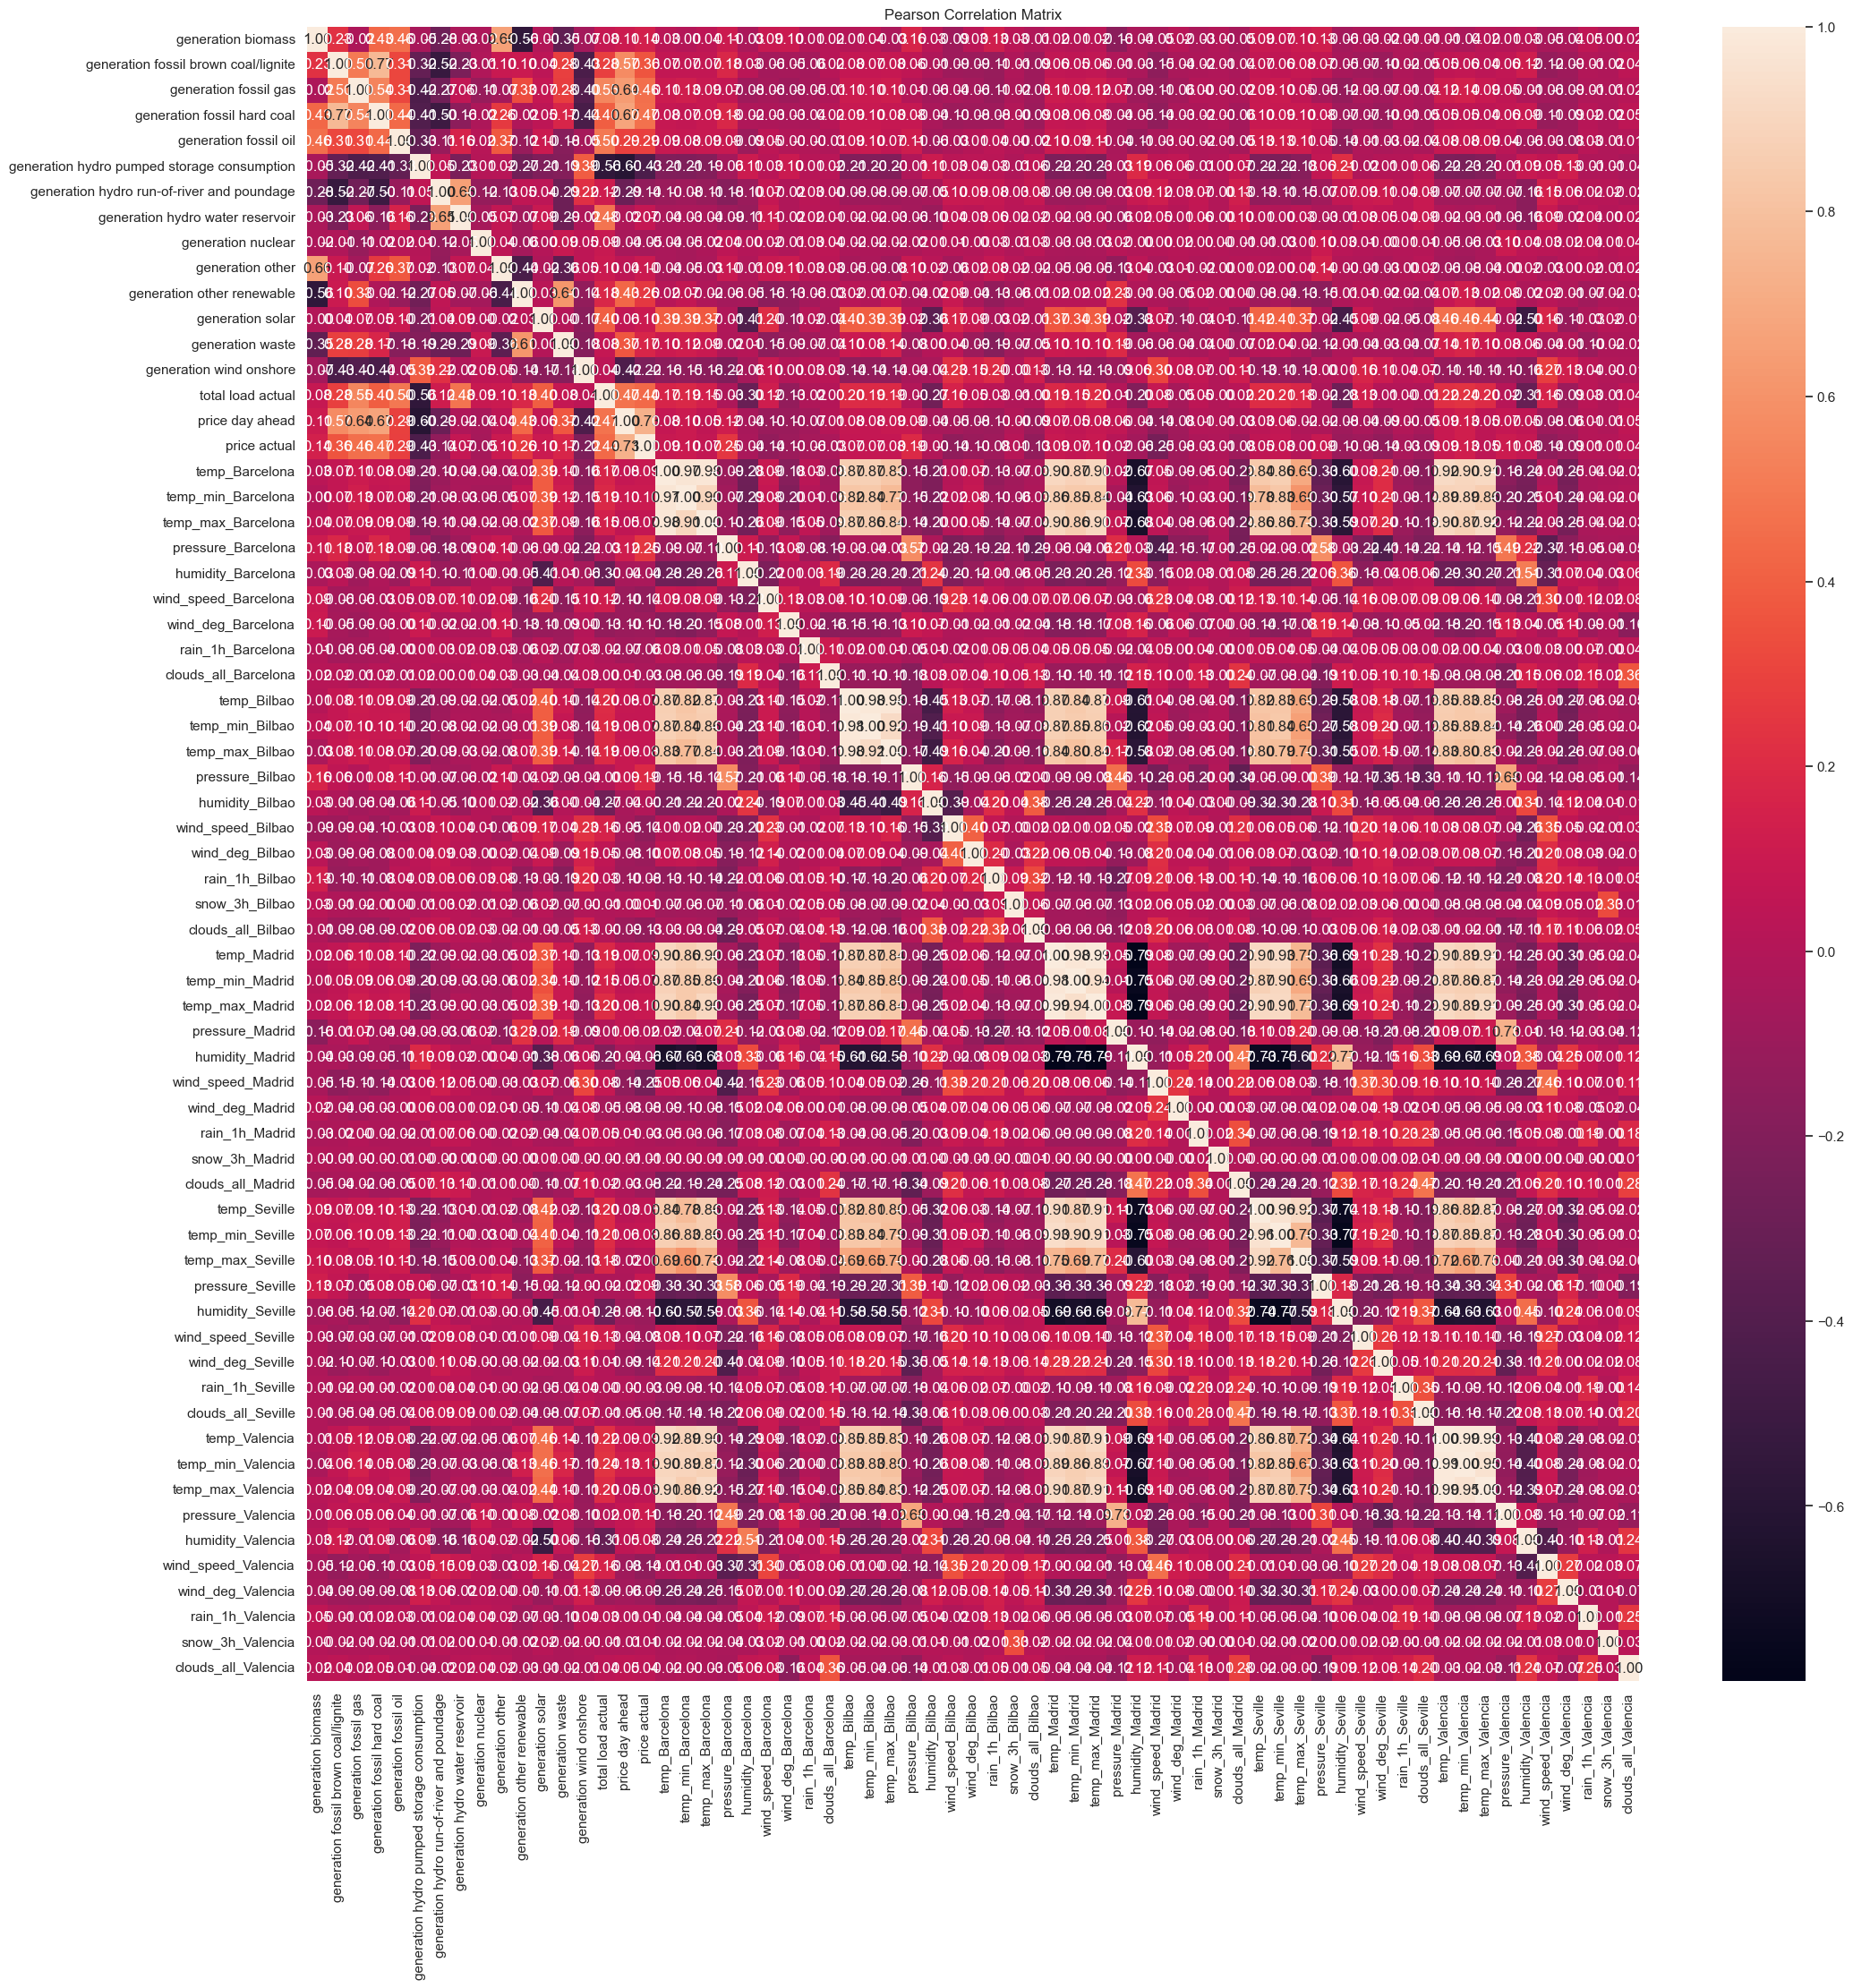

In [65]:
# Plot Pearson correlation matrix

correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [66]:
# identify features that are highly correlated with each other
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
temp_Barcelona                        temp_min_Barcelona                      0.970264
                                      temp_max_Barcelona                      0.976904
                                      temp_Bilbao                             0.866727
                                      temp_min_Bilbao                         0.867970
                                      temp_max_Bilbao                         0.828347
                                      temp_Madrid                             0.903996
                                      temp_min_Madrid                         0.874548
                                      temp_max_Madrid                         0.899010
                                      temp_Seville                            0.841910
                                      temp_

In [67]:
# Pickle export 

with open('data/df_final_viz.pkl', 'wb') as f:
    pickle.dump(df_final,f)